## **Lets Begin..**

In [1]:
# import the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm


from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder

import tensorflow as tf

from sklearn.metrics import r2_score
from prophet import Prophet

import pickle

In [2]:
# read the file
data = pd.read_csv('/content/train.csv')

In [3]:
data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

## **Preproceesing**

1. Null values
2. Handling the dates
3. Removing unwanted columns
4. Converting to category type


1. Null values

We can see that the zip codes are missing.

One simple way is to drop the columns, but I tried another method :/)

I replaced the missing zipcodes with the **mode of zip codes** from that particular city from which the customer has done the purchase



In [5]:
missing_values = data.isnull().sum()
print(missing_values)

Row ID            0
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
Country           0
City              0
State             0
Postal Code      11
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
dtype: int64


In [6]:
mode_zipcodes_by_city = data.groupby('City')['Postal Code'].agg(lambda x: x.mode().iat[0]).to_dict()

# Function to fill missing 'Postal Code' based on city
def fill_missing_postal_code(row):
    if pd.isnull(row['Postal Code']):
        return mode_zipcodes_by_city.get(row['City'], row['Postal Code'])
    else:
        return row['Postal Code']

# Apply the function to fill missing values
data['Postal Code'] = data.apply(fill_missing_postal_code, axis=1)

In [7]:
missing_values = data.isnull().sum()
print(missing_values)

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
dtype: int64


2. Handling the dates

We can take out the year, month and the day as seperate columns,these features can be more informative for time-based analysis and may improve the performance of your machine learning model.

In [8]:
data['Order Date'] = pd.to_datetime(data['Order Date'])
data['Ship Date'] = pd.to_datetime(data['Ship Date'])

data['Order Day'] = data['Order Date'].dt.day
data['Order Month'] = data['Order Date'].dt.month
data['Order Year'] = data['Order Date'].dt.year

data['Ship Day'] = data['Ship Date'].dt.day
data['Ship Month'] = data['Ship Date'].dt.month
data['Ship Year'] = data['Ship Date'].dt.year

<ipython-input-8-23e7c425d4ad>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['Order Date'] = pd.to_datetime(data['Order Date'])
<ipython-input-8-23e7c425d4ad>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['Ship Date'] = pd.to_datetime(data['Ship Date'])


3. Removing unwanted columns

The main reason is these values doesn't provide much importance while anlzing the data.

In [9]:
columns_to_remove = ['Order ID', 'Row ID', 'Customer ID','Customer Name', 'Country', 'Product Name']

# Drop unnecessary columns
data = data.drop(columns=columns_to_remove)

4. Converting to category type

Converting columns to the 'category' data type can be useful for the following reasons:

*   Memory Efficiency
*   Performance Improvement


It is most beneficial for columns with a relatively small number of unique values and where the categorical nature is meaningful.

In [10]:
distinct_values_count = data.nunique()
distinct_values_count_df = pd.DataFrame({'Column': distinct_values_count.index, 'Distinct Values Count': distinct_values_count.values})
print(distinct_values_count_df)

          Column  Distinct Values Count
0     Order Date                   1230
1      Ship Date                   1326
2      Ship Mode                      4
3        Segment                      3
4           City                    529
5          State                     49
6    Postal Code                    626
7         Region                      4
8     Product ID                   1861
9       Category                      3
10  Sub-Category                     17
11         Sales                   5757
12     Order Day                     31
13   Order Month                     12
14    Order Year                      4
15      Ship Day                     31
16    Ship Month                     12
17     Ship Year                      5


In [11]:
columns_to_convert = ['Ship Mode', 'Segment', 'State', 'Region', 'Category', 'Sub-Category']
data[columns_to_convert] = data[columns_to_convert].astype('category')

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Order Date    9800 non-null   datetime64[ns]
 1   Ship Date     9800 non-null   datetime64[ns]
 2   Ship Mode     9800 non-null   category      
 3   Segment       9800 non-null   category      
 4   City          9800 non-null   object        
 5   State         9800 non-null   category      
 6   Postal Code   9800 non-null   float64       
 7   Region        9800 non-null   category      
 8   Product ID    9800 non-null   object        
 9   Category      9800 non-null   category      
 10  Sub-Category  9800 non-null   category      
 11  Sales         9800 non-null   float64       
 12  Order Day     9800 non-null   int64         
 13  Order Month   9800 non-null   int64         
 14  Order Year    9800 non-null   int64         
 15  Ship Day      9800 non-null   int64   

## **Now lets do some Exploratory Data Analysis (EDA)**

1. Distribution of Sales

The plot says that most of the sales are done between the range \$0 - \$1500

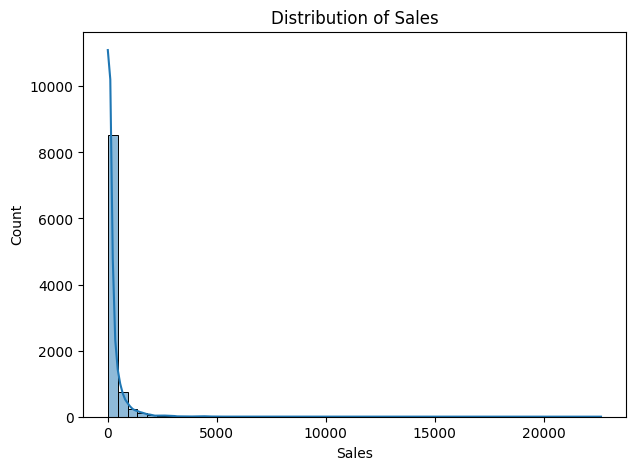

In [13]:
# Distribution of Sales
plt.figure(figsize=(7, 5))
sns.histplot(data['Sales'], bins=50, kde=True)
plt.title('Distribution of Sales')
plt.show()


2. Sales over time (Monthly)

As we can see that the overall sales as an increasing trend over time.

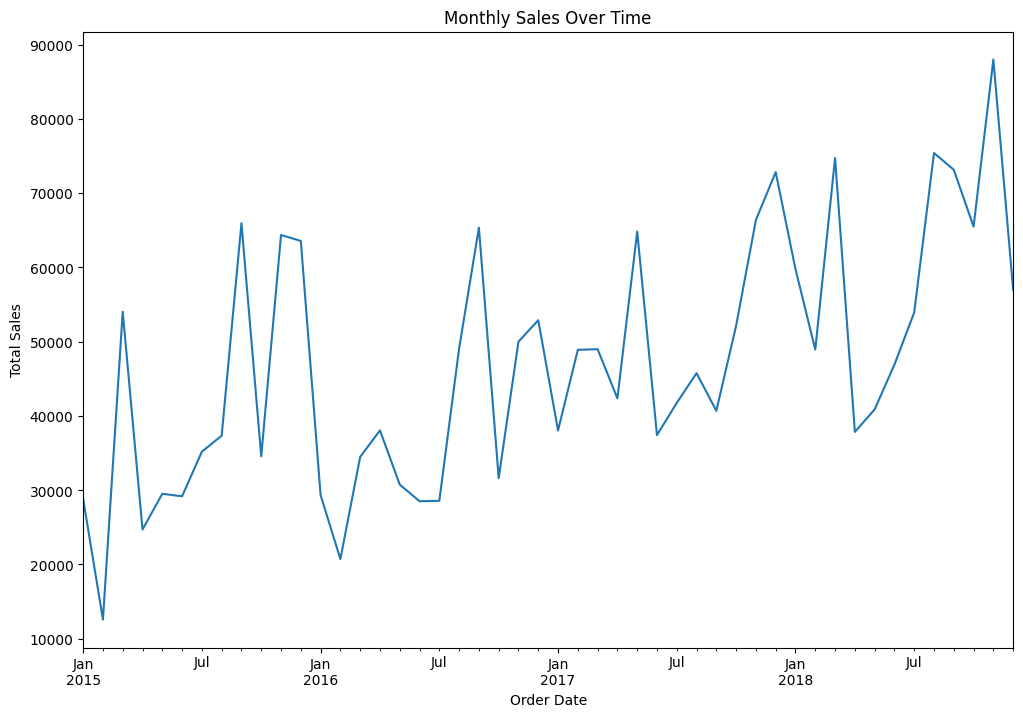

In [14]:
# Sales over time (Monthly)
monthly_sales = data.resample('M', on='Order Date')['Sales'].sum()
plt.figure(figsize=(12, 8))
monthly_sales.plot(kind='line')
plt.title('Monthly Sales Over Time')
plt.xlabel('Order Date')
plt.ylabel('Total Sales')
plt.show()

3. Number of sales by Category

The plot shows that the office supplies are the mostly purchased item all over the US.

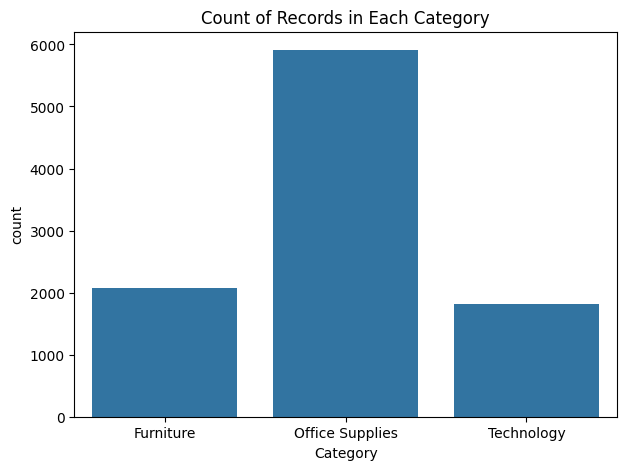

In [15]:
plt.figure(figsize=(7, 5))
sns.countplot(x='Category', data=data)
plt.title('Count of Records in Each Category')
plt.show()

4. Sales by region

breaking the sales by region shows that most of the sales happens in the 'East' and 'West' regions, while 'Central' and 'South' has not contributed much to the sales.

<ipython-input-16-c4e44eaf87d7>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Order Month', y='Sales', hue='Region', data=sales_by_region_year_month, ci=None)


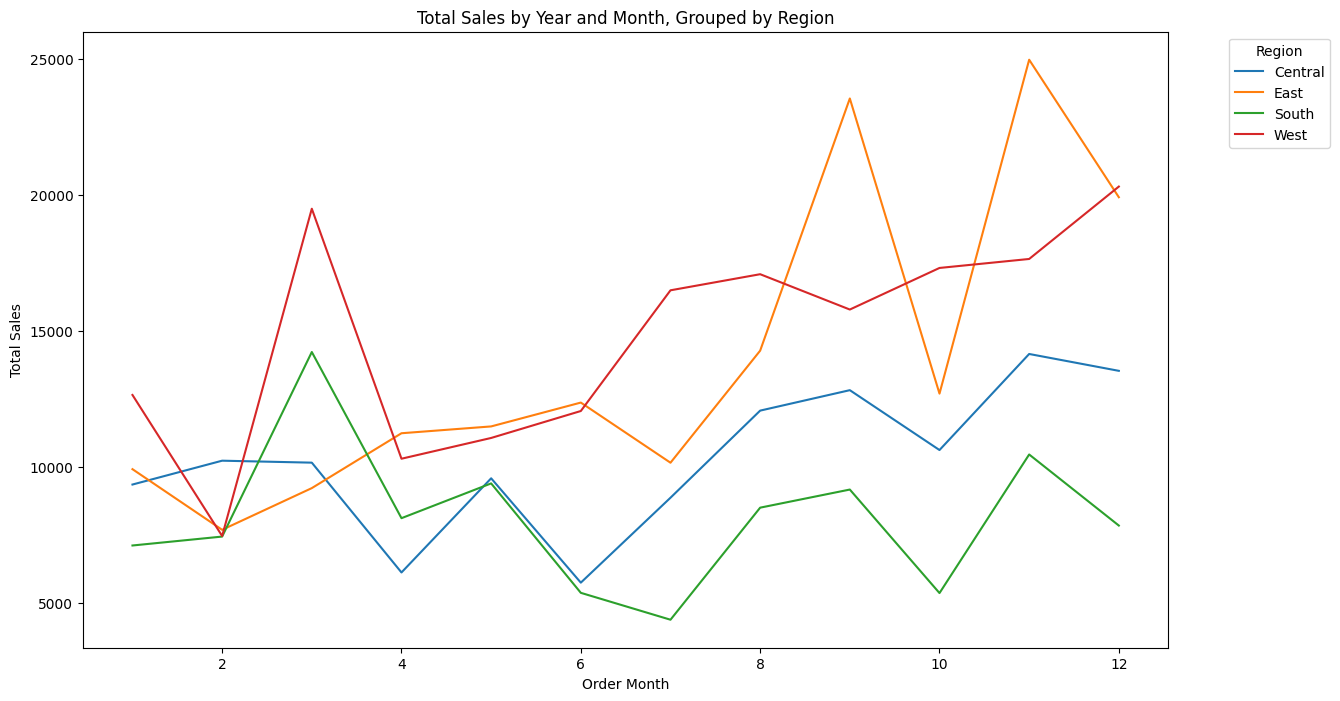

In [16]:
sales_by_region_year_month = data.groupby(['Region', 'Order Year', 'Order Month'])['Sales'].sum().reset_index()

sales_pivot = sales_by_region_year_month.pivot_table(index=['Region', 'Order Year'], columns='Order Month', values='Sales', aggfunc='sum')

sales_by_region_year_month = data.groupby(['Region', 'Order Year', 'Order Month'])['Sales'].sum().reset_index()

plt.figure(figsize=(14, 8))
sns.lineplot(x='Order Month', y='Sales', hue='Region', data=sales_by_region_year_month, ci=None)
plt.title('Total Sales by Year and Month, Grouped by Region')
plt.xlabel('Order Month')
plt.ylabel('Total Sales')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

5. Mean and Standard Deviation

What does this tell us?


The distribution is wider, which means sales over the regions vary by a lot!

In [17]:
mean_sales_by_state = data.groupby('State')['Sales'].sum()

overall_mean_sales = mean_sales_by_state.mean()
std = mean_sales_by_state.std()

print("Mean Sales for All States (Grouped):", overall_mean_sales)
print("Standard deviation Sales for All States (Grouped):", std)

Mean Sales for All States (Grouped): 46153.81189183673
Standard deviation Sales for All States (Grouped): 79088.81226337305


6. Let's find the favourite category of each region


Items related to Tech have been purchased the most by the people in all the region

Ofcourse Tech has contributed to the most sales in all regions!




In [18]:

total_sales_by_region_category = data.groupby(['Region', 'Category'])['Sales'].sum().reset_index()
max_sales_index = total_sales_by_region_category.groupby('Region')['Sales'].idxmax()
most_saled_items_by_region = total_sales_by_region_category.loc[max_sales_index]

print("Most Saled Item by Category for Each Region:")
print(most_saled_items_by_region)

Most Saled Item by Category for Each Region:
     Region    Category       Sales
2   Central  Technology  168739.208
5      East  Technology  263116.527
8     South  Technology  148195.208
11     West  Technology  247404.930


But we should not jump into the conclusion, now let's see the top 10 and bottom 10 states by sales and break them down by category

7. Top 10 states (with category) by sales

One common trend is that in the top 10 states, all categories have almost same contribution

<Figure size 2500x1200 with 0 Axes>

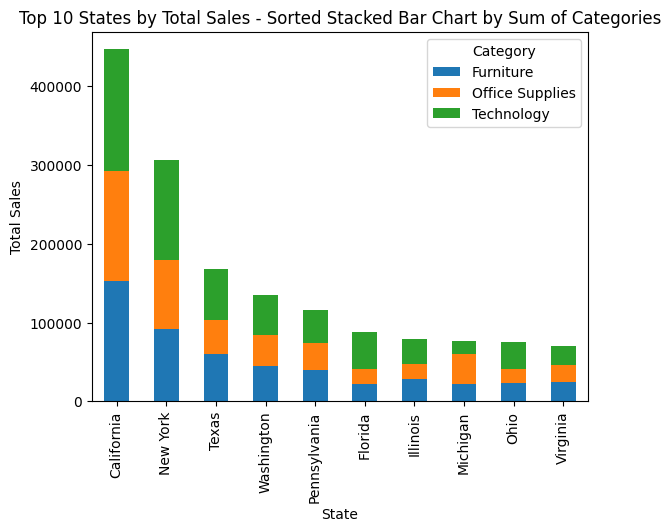

In [19]:
total_sales_by_state_category = data.groupby(['State', 'Category'])['Sales'].sum().reset_index()
total_sales_by_state =  data.groupby(['State'])['Sales'].sum().reset_index()
ranked_states = total_sales_by_state.groupby('State')['Sales'].sum().sort_values(ascending=False).head(10).index
top_10_states_data = total_sales_by_state_category[total_sales_by_state_category['State'].isin(ranked_states)]

pivot_data = top_10_states_data.pivot(index='State', columns='Category', values='Sales').fillna(0)
sorted_pivot_data = pivot_data.loc[pivot_data.sum(axis=1).sort_values(ascending=False).index]

plt.figure(figsize=(25, 12))
sorted_pivot_data.plot(kind='bar', stacked=True)
plt.title('Top 10 States by Total Sales - Sorted Stacked Bar Chart by Sum of Categories')
plt.xlabel('State')
plt.ylabel('Total Sales')
plt.legend(title='Category')
plt.show()

8. Bottom 10 states (with category) by sales

On the other hand, the bottom 10 has a non-uniform distribution.

Also development plays a crucial role in sales.

<Figure size 1600x800 with 0 Axes>

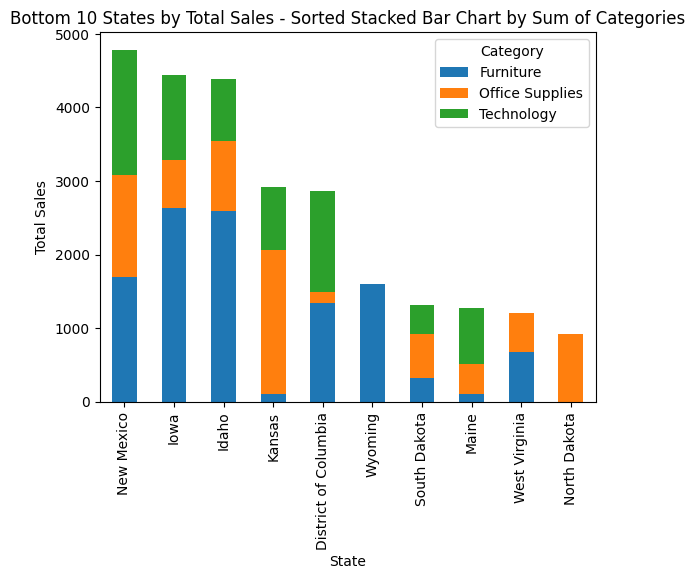

In [20]:
total_sales_by_state_category = data.groupby(['State', 'Category'])['Sales'].sum().reset_index()
ranked_states = total_sales_by_state.groupby('State')['Sales'].sum().sort_values(ascending=False).tail(10).index

bottom_10_states_data = total_sales_by_state_category[total_sales_by_state_category['State'].isin(ranked_states)]

pivot_data = bottom_10_states_data.pivot(index='State', columns='Category', values='Sales').fillna(0)

sorted_pivot_data = pivot_data.loc[pivot_data.sum(axis=1).sort_values(ascending=False).index]

plt.figure(figsize=(16, 8))
sorted_pivot_data.plot(kind='bar', stacked=True)
plt.title('Bottom 10 States by Total Sales - Sorted Stacked Bar Chart by Sum of Categories')
plt.xlabel('State')
plt.ylabel('Total Sales')
plt.legend(title='Category')
plt.show()

9. Category Sales over years

Tech has contributed to the sales largely

In [21]:
data['Order Date'] = pd.to_datetime(data['Order Date'])
data['Year'] = data['Order Date'].dt.year

yearly_category_sales = data.groupby(['Year', 'Category'])['Sales'].sum().reset_index()

pivot_table = yearly_category_sales.pivot(index='Year', columns='Category', values='Sales').fillna(0)


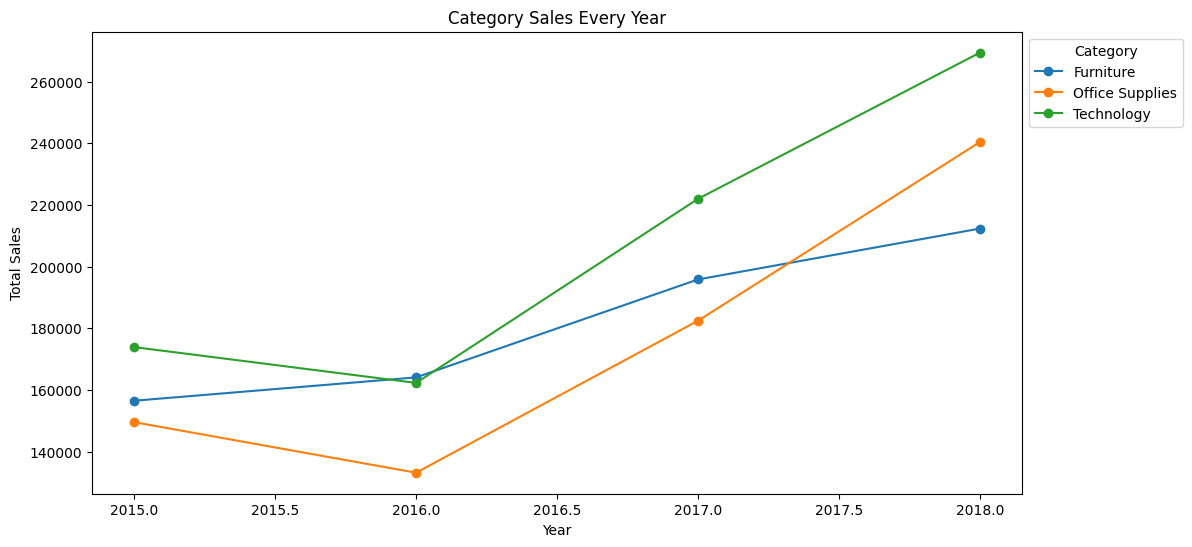

In [22]:
plt.figure(figsize=(12, 6))
for category in pivot_table.columns:
    plt.plot(pivot_table.index, pivot_table[category], marker='o', label=category)

plt.title('Category Sales Every Year')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.legend(title='Category', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

10. Seasonal Trends by year


We can see that in all 4 years, the 4th quarter has the most significant sales.

Holiday season right !!

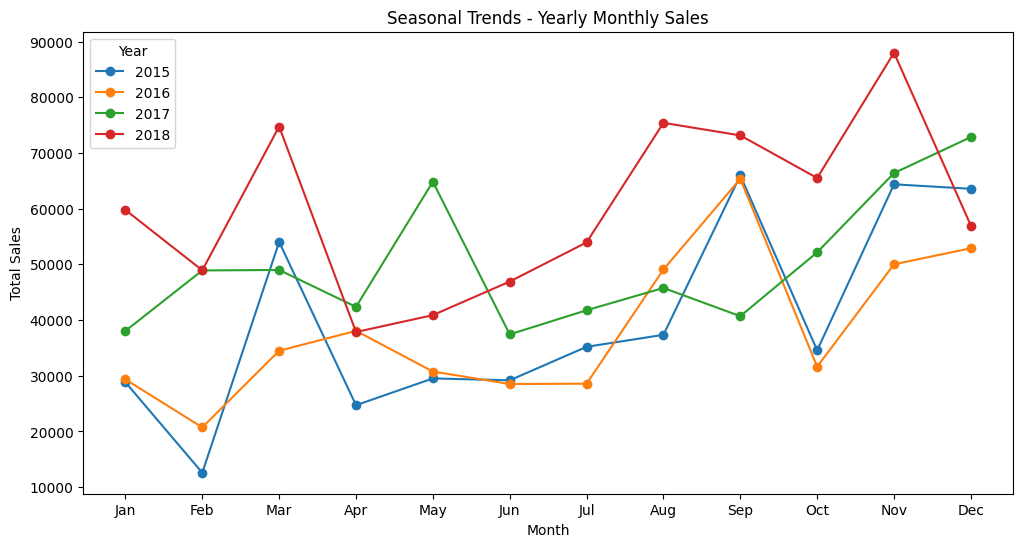

In [23]:
import pandas as pd
data['Year'] = data['Order Date'].dt.year
data['Month'] = data['Order Date'].dt.month
yearly_monthly_sales = data.groupby(['Year', 'Month'])['Sales'].sum().reset_index()

# Plotting seasonal trends year-wise in a single plot
plt.figure(figsize=(12, 6))

for year in yearly_monthly_sales['Year'].unique():
    year_data = yearly_monthly_sales[yearly_monthly_sales['Year'] == year]
    plt.plot(year_data['Month'], year_data['Sales'], marker='o', label=year)

plt.title('Seasonal Trends - Yearly Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')
plt.show()

11. Seasonal Trends all years (sum)


Once again the trend of high sales in final quarter is confirmed!

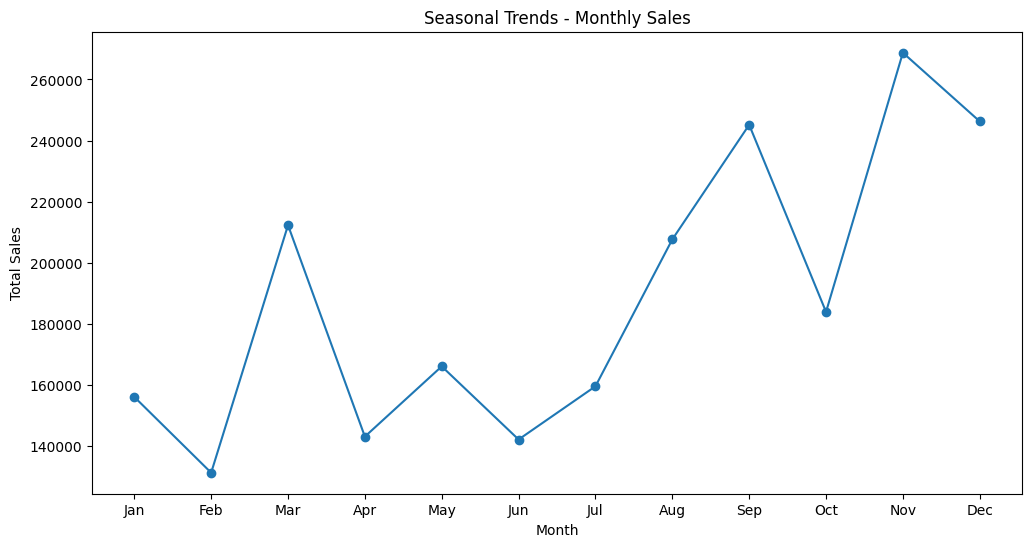

In [24]:
data['Order Date'] = pd.to_datetime(data['Order Date'])

# Extract month from 'Order Date'
data['Month'] = data['Order Date'].dt.month

# Group by month and calculate total sales for each month
monthly_sales = data.groupby('Month')['Sales'].sum()

# Plotting seasonal trends using a line plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales.values, marker='o')
plt.title('Seasonal Trends - Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

Let's check for Time series now

12. Break down of trends by Month

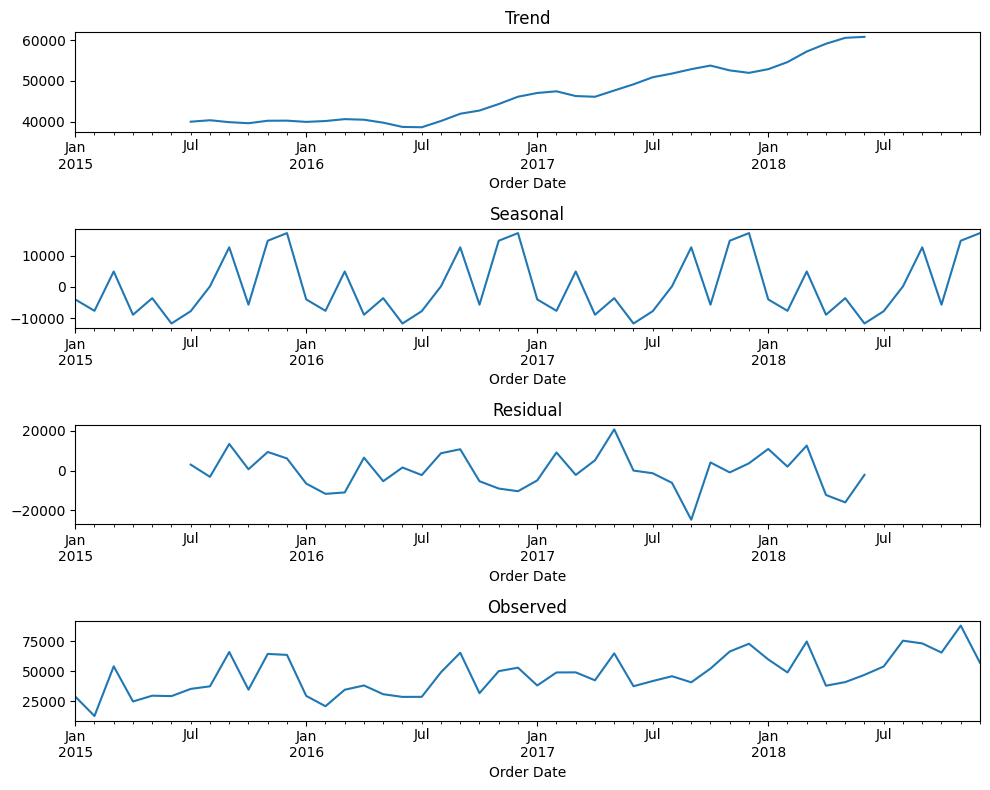

In [25]:

df_copy = data.copy()


df_copy['Order Date'] = pd.to_datetime(df_copy['Order Date'])

df_copy.set_index('Order Date', inplace=True)
df_monthly = df_copy['Sales'].resample('M').sum()
decomposition_monthly = sm.tsa.seasonal_decompose(df_monthly, model='additive')


fig, axes = plt.subplots(4, 1, figsize=(10, 8))
decomposition_monthly.trend.plot(ax=axes[0])
axes[0].set_title('Trend')
decomposition_monthly.seasonal.plot(ax=axes[1])
axes[1].set_title('Seasonal')
decomposition_monthly.resid.plot(ax=axes[2])
axes[2].set_title('Residual')
decomposition_monthly.observed.plot(ax=axes[3])
axes[3].set_title('Observed')

plt.tight_layout()
plt.show()


13. Break down of trends by Day

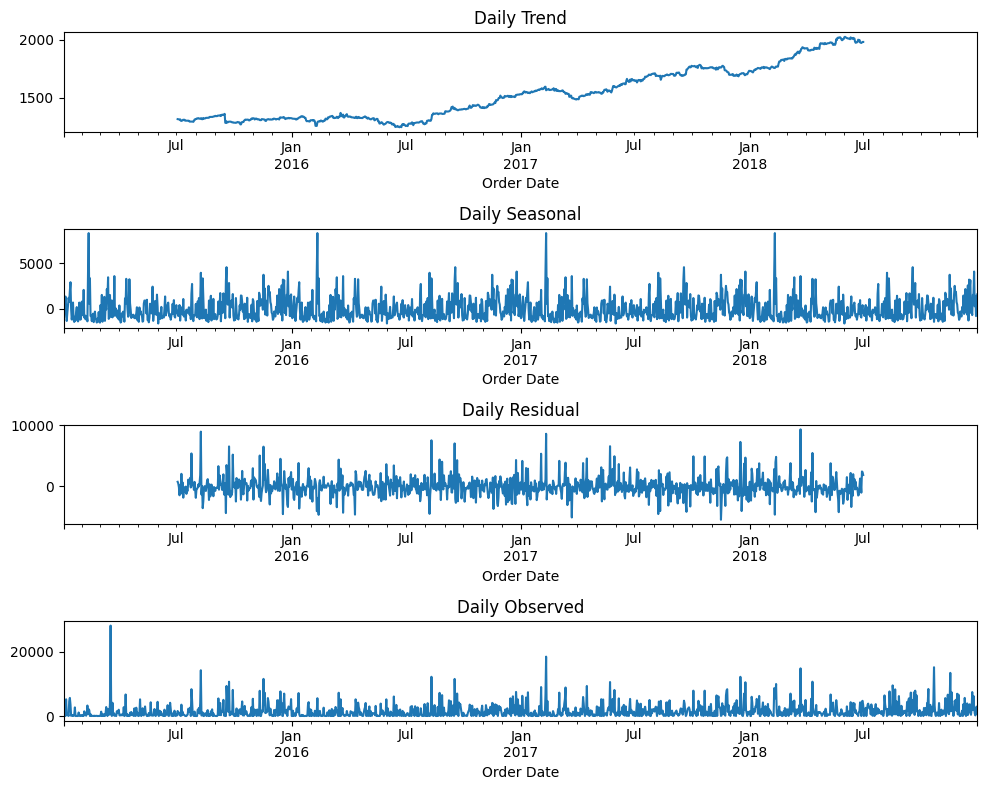

In [26]:
df_copy = data.copy()

df_copy['Order Date'] = pd.to_datetime(df_copy['Order Date'])
df_copy.set_index('Order Date', inplace=True)
df_daily = df_copy['Sales'].resample('D').sum()
decomposition_daily = sm.tsa.seasonal_decompose(df_daily, model='additive',period=365)


fig, axes = plt.subplots(4, 1, figsize=(10, 8))
decomposition_daily.trend.plot(ax=axes[0])
axes[0].set_title('Daily Trend')
decomposition_daily.seasonal.plot(ax=axes[1])
axes[1].set_title('Daily Seasonal')
decomposition_daily.resid.plot(ax=axes[2])
axes[2].set_title('Daily Residual')
decomposition_daily.observed.plot(ax=axes[3])
axes[3].set_title('Daily Observed')

plt.tight_layout()
plt.show()

## **Both decompositions prove us that there are strong seasonality trends and we can proceed with Time Series models**

## **Facebook's Prophet model**

Prophet is particularly well-suited for business time series forecasting tasks, such as predicting sales, demand, or any other time-based patterns.

Key features of Prophet include:

Flexibility: Prophet can handle hourly, daily, or other time intervals, and it can also handle missing data and outliers.

Automatic Seasonality Detection: Prophet can automatically detect and incorporate yearly, weekly, and daily seasonality in the data.

Holiday Effects: It allows the inclusion of custom holidays and their impact on the time series.

Additive or Multiplicative Components: Prophet models time series data as a combination of trend, seasonality, and holidays, with the option to use additive or multiplicative components.

Saturation Minimum: It supports modeling data with a saturation minimum, which is useful for data that has a lower limit.


Lets try this model!



In [27]:
df_copy = data[['Order Date', 'Sales']].copy()
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Order Date  9800 non-null   datetime64[ns]
 1   Sales       9800 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 153.2 KB


In [28]:


df_copy['Order Date'] = pd.to_datetime(df_copy['Order Date'])

# Resample the data to monthly frequency and sum the sales for each month
monthly_data = df_copy.resample('M', on='Order Date').sum()

# Rename columns as 'ds' and 'y' as required by Prophet
monthly_data.reset_index(inplace=True)
monthly_data = monthly_data.rename(columns={'Order Date': 'ds', 'Sales': 'y'})

# Initialize and fit the Prophet model
model = Prophet()
model.fit(monthly_data)

# Create a future dataframe for the next 12 months
future = model.make_future_dataframe(periods=12, freq='M')

# Make forecasts for the future
forecast = model.predict(future)

# Extract the actual data and forecast for the next 12 months
actual_data = monthly_data['y']
fitted_data = forecast['yhat'][:len(monthly_data)]  # Fitted values for the historical data
forecast_data = forecast['yhat'][len(monthly_data):]

# Calculate R-squared score for the fitted data
r2_fitted = 1 - np.sum((actual_data - fitted_data) ** 2) / np.sum((actual_data - actual_data.mean()) ** 2)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp129cmyyg/rrbb7tmp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp129cmyyg/vk48j3b2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51510', 'data', 'file=/tmp/tmp129cmyyg/rrbb7tmp.json', 'init=/tmp/tmp129cmyyg/vk48j3b2.json', 'output', 'file=/tmp/tmp129cmyyg/prophet_modelsz9nd709/prophet_model-20240130024552.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:45:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:45:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


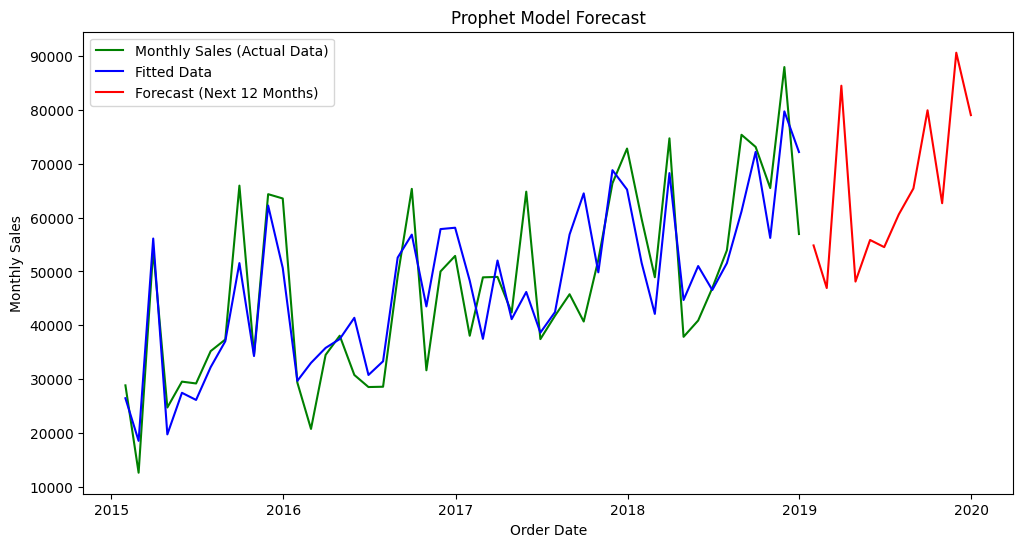

R-squared score for fitted data: 0.75


In [29]:
# Plot the actual data, fitted data, and forecast for the next 12 months
plt.figure(figsize=(12, 6))
plt.plot(monthly_data['ds'], actual_data, label='Monthly Sales (Actual Data)', color='green')
plt.plot(monthly_data['ds'], fitted_data, label='Fitted Data', color='blue')
plt.plot(forecast['ds'][len(monthly_data):], forecast_data, label='Forecast (Next 12 Months)', color='red')

plt.legend()
plt.xlabel('Order Date')
plt.ylabel('Monthly Sales')
plt.title('Prophet Model Forecast')
plt.show()

# Display R-squared score for the fitted data
print(f"R-squared score for fitted data: {r2_fitted:.2f}")

In [30]:
with open('prophet_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

Conclusion:


As part of this work, We did preprocessing of the data, performed EDA to analze the trends, and built a ML model.

Every dataset has numerous stories waiting to be discovered with data visualization and analytics, This is my version :\)

 1. The sales is directly related with the development of the region.
 2. Majority of the sales has been in the range $0 - $1500.
 3. East and West region has the highest gross sales.
 4. Gross sales is moving in a positive trend.
 5. Tech has been the favourite in terms of sales across the country.
 6. All categories have uniform distribution in sales in the top 10 cities while its not the case in the bottom 10.
 7. Thanksgiving and Holiday season are the best sales period.
 8. The sales is having trend over the years making it suitable for time series analysis.
 9. Finally we build a Time Series model.

 These insights can be helpful to improve the sales, especially by providing additional care to the 'Central' and the 'South' regions.

The performance of the ML model can be improved.

I have designed an interactive dashboard, which digs more into data, helping me discover meaningful insights and build beautiful visulaizations.


Here is the link:

Do share your thoughts,

Praveen Raj Mohanraj
pmohanr4@asu.edu


